<a href="https://colab.research.google.com/github/lukmanaj/ArewaDS-Deep-Learning-with-PyTorch-Assignments/blob/main/Deep_Learning_with_PyTorch/week_06/week_6_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Arewa DataScience Academy
### Deep Learning Cohort 1.0

### WEEK 6 Exercises

####Name : Lukman Aliyu Jibril

####email: lukman.j.aliyu@gmail.com


### Exercises:
Please, see week 6 exercises from [**Learn PyTorch for Deep Learning**](https://www.learnpytorch.io/):\
[06. Pytorch Transfer Learning](https://www.learnpytorch.io/05_pytorch_transfer_learning/#exercises)

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (4056/4056), done.
remote: Compressing objects: 100% (1626/1626), done.
remote: Total 4056 (delta 2387), reused 3946 (delta 2369), pack-reused 0
Receiving objects: 100% (4056/4056), 649.87 MiB | 28.48 MiB/s, done.
Resolving deltas: 100% (2387/2387), done.
Updating files: 100% (248/248), done.


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi

Sat Feb  3 20:18:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8               8W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Get data

In [4]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/lukmanaj/ArewaDS-Deep-Learning-with-PyTorch-Assignments/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


### Prepare data

In [5]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [6]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c73da481120>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [8]:
# Setup the model with pretrained weights and send it to the target device
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT # best available weight
model_0 = torchvision.models.efficientnet_b1(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 140MB/s]


In [9]:
summary(model_0,input_size = [32,3,224,224],col_names=["input_size","output_size","trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 1000]                True
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          True
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        True
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        True
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        True
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 32, 112, 112]        [32, 16, 112, 112]        True
│    │    └─MBConv: 3-4                                 [32, 32, 112, 112]        [32, 16, 11

In [10]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False
# Check summary again after
summary(model_0, input_size= [32,3,224,224],col_names= ["input_size","output_size","trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 1000]                Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 32, 112, 112]        [32, 16, 112, 112]        False
│    │    └─MBConv: 3-4                                 [32, 32, 112, 112]        [32

In [12]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [13]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [14]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0675 | train_acc: 0.5391 | test_loss: 0.9913 | test_acc: 0.7235
Epoch: 2 | train_loss: 0.9406 | train_acc: 0.7109 | test_loss: 0.9386 | test_acc: 0.7443
Epoch: 3 | train_loss: 0.8566 | train_acc: 0.8594 | test_loss: 0.8468 | test_acc: 0.8475
Epoch: 4 | train_loss: 0.8440 | train_acc: 0.7578 | test_loss: 0.7715 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.7215 | train_acc: 0.7656 | test_loss: 0.7288 | test_acc: 0.8674
[INFO] Total training time: 10.456 seconds


### Make predictions on the entire test dataset with the model

In [15]:
# TODO
len(test_dataloader)

3

In [16]:
from tqdm.auto import tqdm
model_0.eval()
test_preds = []
with torch.inference_mode():
    for X,y in tqdm(test_dataloader):
        # move data to device
        X, y = X.to(device), y.to(device)
        # pass the data to the model
        test_logits = model_0(X)
        # get the probs using softmax
        pred_probs = torch.softmax(test_logits,dim=1)
        # get the class labels
        pred_probs_labels = torch.argmax(pred_probs,dim=1)
        # store in test_preds list
        test_preds.append(pred_probs_labels)

# concatenate to a tensor and take to cpu for further analysis
test_preds = torch.cat(test_preds).cpu()


  0%|          | 0/3 [00:00<?, ?it/s]

In [17]:
test_preds

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2,
        1, 2, 2])

### Make a confusion matrix with the test preds and the truth labels

In [18]:
y_test_true = [y for X,y in test_dataloader]
y_test_true

[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 1, 1, 1, 1, 1, 1]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2]),
 tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])]

In [19]:
# Need to concatenate them
y_test_true = torch.cat(y_test_true)
y_test_true

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [20]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.9 MB/s eta 0:00:00
mlxtend version: 0.23.1


In [21]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


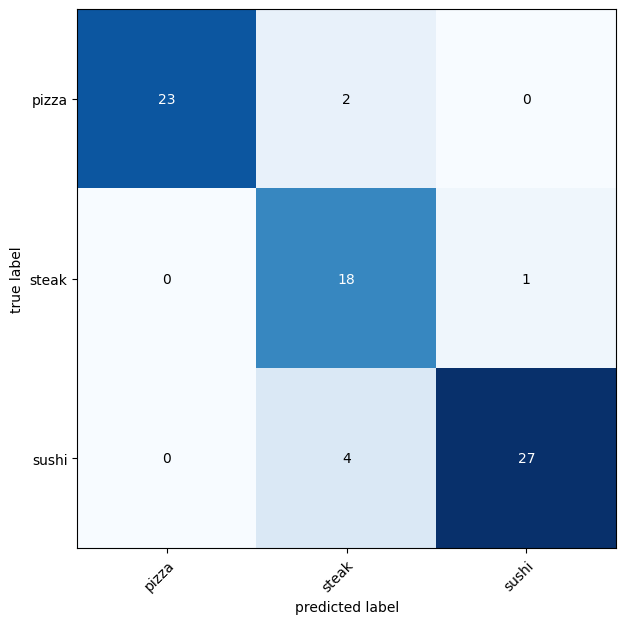

In [22]:
# TODO

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance
confmat = ConfusionMatrix(task= "multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=test_preds,
                         target=y_test_true)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    figsize=(10, 7)
)

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [23]:
# Get all test data paths
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
    test_pred_list = []
    for path in tqdm(test_paths):
        # Create empty dict to store info for each sample
        pred_dict = {}

        # Get sample path
        pred_dict["image_path"] = path

         # Get class name
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

      # Get prediction and prediction probability
        from PIL import Image
        img = Image.open(path) # open image
        transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
        model.eval()
        with torch.inference_mode():
            pred_logit = model(transformed_image.to(device))
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]

            # Make sure things in the dictionary are back on the CPU
            pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
            pred_dict["pred_class"] = pred_class

       # Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # print(pred_dict)
    # Add the dictionary to the list of preds
        test_pred_list.append(pred_dict)

    return test_pred_list

test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=model_0,
                                 transform=simple_transform,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts[:5]


  0%|          | 0/75 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/steak/966174.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.5503523945808411,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/3873283.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.4400987923145294,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7417910695075989,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.6455128788948059,
  'pred_class': 'steak',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/1882831.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.6589924097061157,
  'pred_class': 'steak',
  'correct': True}]

In [24]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
# Sort DataFrame by correct then by pred_prob
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,correct
11,data/pizza_steak_sushi/test/steak/1627703.jpg,steak,0.453666,sushi,False
49,data/pizza_steak_sushi/test/sushi/499605.jpg,sushi,0.453101,steak,False
61,data/pizza_steak_sushi/test/sushi/684266.jpg,sushi,0.437856,steak,False
39,data/pizza_steak_sushi/test/pizza/971934.jpg,pizza,0.413110,steak,False
36,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.392067,steak,False


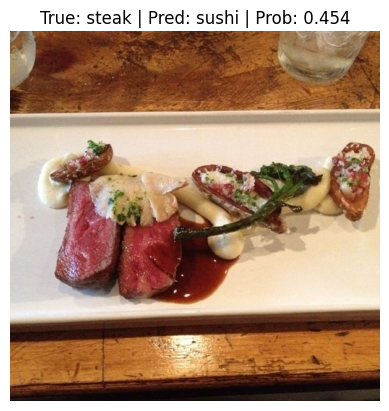

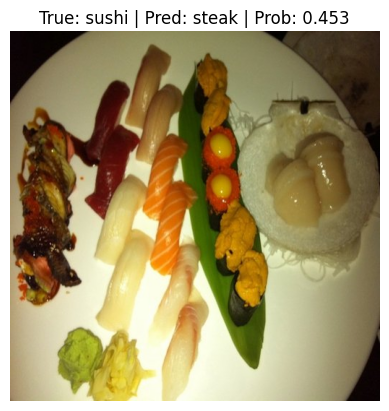

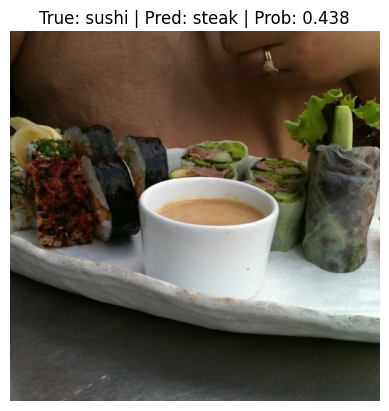

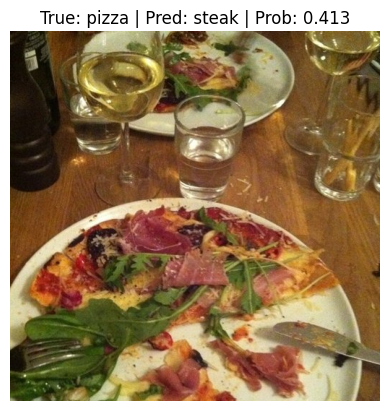

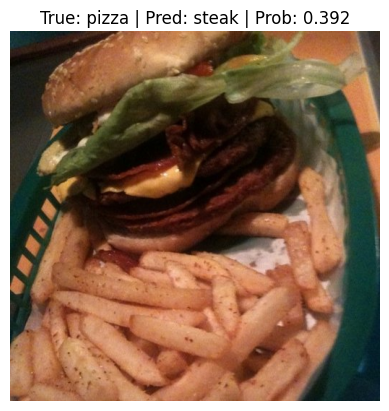

In [25]:
import torchvision
import matplotlib.pyplot as plt
# Plot the top 5 most wrong images
for row in top_5_most_wrong.iterrows():
    row = row[1]
    image_path = row.iloc[0]
    true_label = row.iloc[1]
    pred_prob = row.iloc[2]
    pred_class = row.iloc[3]
  # Plot the image and various details
    img = torchvision.io.read_image(str(image_path)) # get image as tensor
    plt.figure()
    plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in [height, width, color_channels]
    plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
    plt.axis(False);

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

--2024-02-03 20:24:17--  https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
Resolving images.unsplash.com (images.unsplash.com)... 199.232.150.208, 2a04:4e42:65::720
Connecting to images.unsplash.com (images.unsplash.com)|199.232.150.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3208960 (3.1M) [image/jpeg]
Saving to: ‘photo-1588315029754-2dd089d39a1a’

photo-1588315029754 100%[===================>]   3.06M  --.-KB/s    in 0.03s   

2024-02-03 20:24:18 (120 MB/s) - ‘photo-1588315029754-2dd089d39a1a’ saved [3208960/3208960]



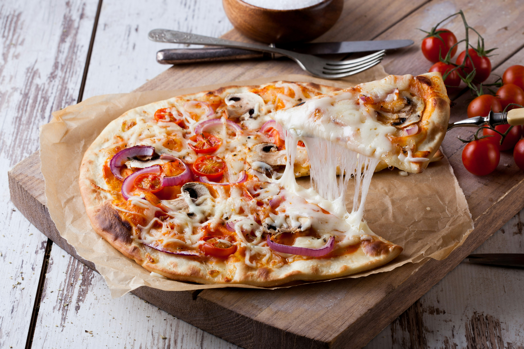

In [26]:
# TODO: Get an image of pizza/steak/sushi
# Get an image of pizza/steak/sushi
!wget https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
!cp photo-1588315029754-2dd089d39a1a pizza.jpg

from PIL import Image

with Image.open("pizza.jpg") as img:
    # Reduce the image size and width by 10
    (width, height) = (img.width // 10, img.height // 10)
    img_resized = img.resize((width, height))

img_resized


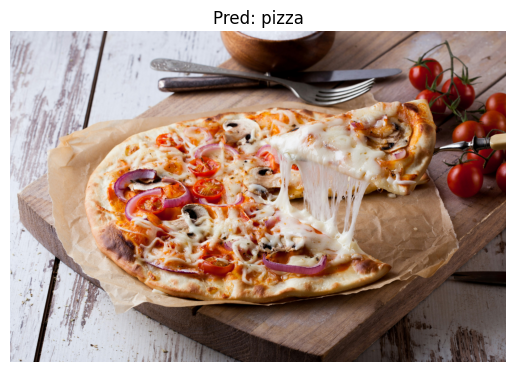

In [27]:
# Make a function to pred and plot images
def pred_and_plot(image_path, model, transform, class_names, device=device):
    # open image
    image = Image.open(image_path)

    # transform image
    transformed_image = transform(image)

    # pred on image
    model.eval()
    with torch.inference_mode():
        pred_logit = model(transformed_image.unsqueeze(0).to(device))
        pred_label = torch.argmax(torch.softmax(pred_logit, dim=1), dim=1)

    # plot image and pred
    plt.figure()
    plt.imshow(image)
    plt.title(f"Pred: {class_names[pred_label]}")
    plt.axis(False);

pred_and_plot(image_path="pizza.jpg",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)

--2024-02-03 20:24:39--  https://images.unsplash.com/photo-1546964124-0cce460f38ef
Resolving images.unsplash.com (images.unsplash.com)... 199.232.150.208, 2a04:4e42:65::720
Connecting to images.unsplash.com (images.unsplash.com)|199.232.150.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3617320 (3.4M) [image/jpeg]
Saving to: ‘photo-1546964124-0cce460f38ef’

photo-1546964124-0c 100%[===================>]   3.45M  --.-KB/s    in 0.03s   

2024-02-03 20:24:39 (129 MB/s) - ‘photo-1546964124-0cce460f38ef’ saved [3617320/3617320]



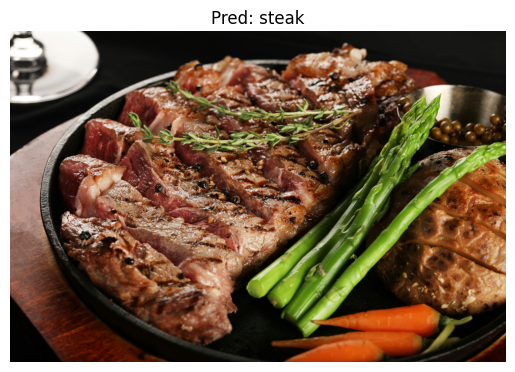

In [28]:
# TODO: Get an image of not pizza/steak/sushi
# Try again on a photo of steak from unsplash.com
!wget https://images.unsplash.com/photo-1546964124-0cce460f38ef
!cp photo-1546964124-0cce460f38ef steak.jpg

pred_and_plot("steak.jpg",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)


## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [30]:
# TODO: Recreate a new model
# Recreate a new model
import torchvision
from torch import nn
weights= torchvision.models.EfficientNet_B1_Weights.DEFAULT
model_1 = torchvision.models.efficientnet_b1(weights=weights).to(device)

# Freeze the base layers
for param in model_1.features.parameters():
    param.requires_grad = False

# Change the classification head
torch.manual_seed(42)
model_1.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

summary(model_1,
        input_size=[32, 3, 224, 224],
        col_names=["input_size", "output_size", "trainable"])


Layer (type:depth-idx)                                  Input Shape               Output Shape              Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 3]                   Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 32, 112, 112]        [32, 16, 112, 112]        False
│    │    └─MBConv: 3-4                                 [32, 32, 112, 112]        [32

In [31]:
# TODO: Train the model for 10 epochs
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Create loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

# Setup training and save the results
model_1_results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0675 | train_acc: 0.5391 | test_loss: 0.9913 | test_acc: 0.7235
Epoch: 2 | train_loss: 0.9406 | train_acc: 0.7109 | test_loss: 0.9386 | test_acc: 0.7443
Epoch: 3 | train_loss: 0.8566 | train_acc: 0.8594 | test_loss: 0.8468 | test_acc: 0.8475
Epoch: 4 | train_loss: 0.8440 | train_acc: 0.7578 | test_loss: 0.7715 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.7215 | train_acc: 0.7656 | test_loss: 0.7288 | test_acc: 0.8674
Epoch: 6 | train_loss: 0.6664 | train_acc: 0.9375 | test_loss: 0.6673 | test_acc: 0.9081
Epoch: 7 | train_loss: 0.6495 | train_acc: 0.9219 | test_loss: 0.6412 | test_acc: 0.8977
Epoch: 8 | train_loss: 0.6290 | train_acc: 0.7812 | test_loss: 0.6040 | test_acc: 0.8873
Epoch: 9 | train_loss: 0.6355 | train_acc: 0.8008 | test_loss: 0.5748 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.5557 | train_acc: 0.9023 | test_loss: 0.5214 | test_acc: 0.9489
[INFO] Total training time: 20.033 seconds


[INFO] Couldn't find helper_functions.py, downloading...


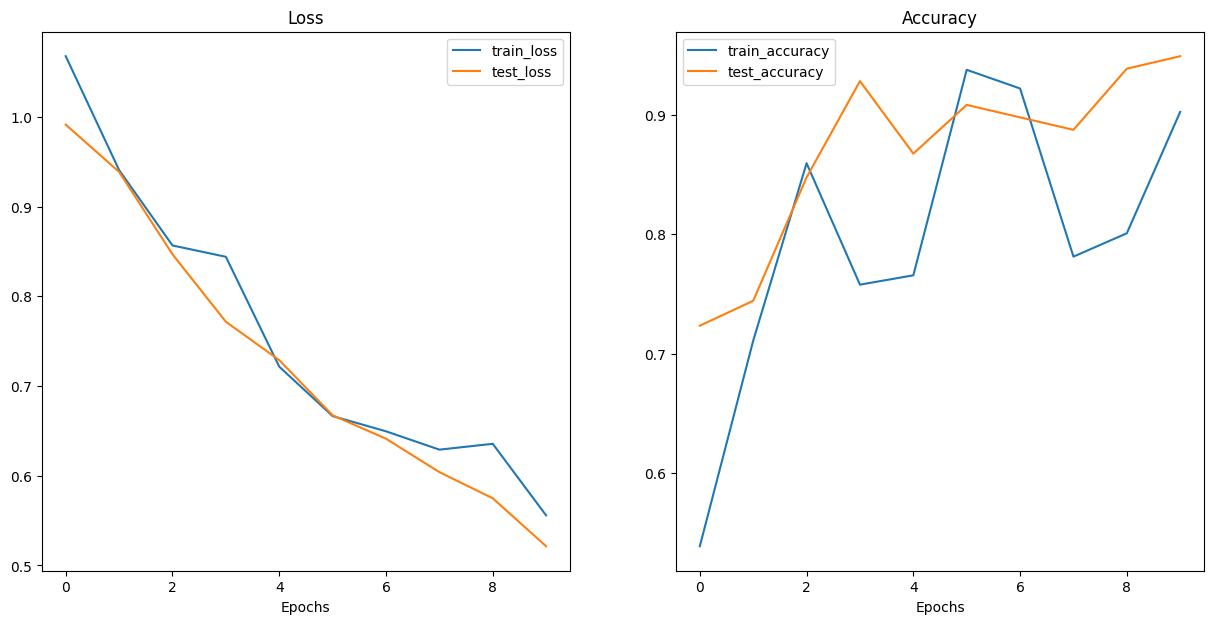

In [32]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(model_1_results)


## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


### Get 20% data

In [33]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [34]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [35]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c7311526080>,
 ['pizza', 'steak', 'sushi'])

In [36]:
len(train_dataloader_20_percent), len(test_dataloader_20_percent)


(15, 5)

### Get a pretrained model

In [37]:
# TODO
import torchvision
from torch import nn
weights= torchvision.models.EfficientNet_B1_Weights.DEFAULT
model_2 = torchvision.models.efficientnet_b1(weights=weights).to(device)

# Freeze the base layers
for param in model_2.features.parameters():
    param.requires_grad = False

# Change the classification head
torch.manual_seed(42)
model_2.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

summary(model_2,
        input_size=[32, 3, 224, 224],
        col_names=["input_size", "output_size", "trainable"])



Layer (type:depth-idx)                                  Input Shape               Output Shape              Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 3]                   Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 32, 112, 112]        [32, 16, 112, 112]        False
│    │    └─MBConv: 3-4                                 [32, 32, 112, 112]        [32

### Train a model with 20% of the data

In [38]:
# TODO
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_2_results = engine.train(model=model_2,
                              train_dataloader=train_dataloader_20_percent,
                              test_dataloader=test_dataloader_20_percent,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=5,
                              device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0242 | train_acc: 0.5625 | test_loss: 0.8819 | test_acc: 0.8642
Epoch: 2 | train_loss: 0.8294 | train_acc: 0.8208 | test_loss: 0.7230 | test_acc: 0.9097
Epoch: 3 | train_loss: 0.7191 | train_acc: 0.8875 | test_loss: 0.6477 | test_acc: 0.9290
Epoch: 4 | train_loss: 0.6054 | train_acc: 0.9187 | test_loss: 0.5621 | test_acc: 0.9040
Epoch: 5 | train_loss: 0.5317 | train_acc: 0.8938 | test_loss: 0.4765 | test_acc: 0.9074
[INFO] Total training time: 18.559 seconds


In [39]:
# Check results with 10% of data for 5 epochs
max(model_0_results["test_acc"]), min(model_0_results["test_loss"])

(0.9280303030303031, 0.7288296620051066)

In [40]:
# Check results with 20% of data for 5 epochs
max(model_2_results["test_acc"]), min(model_2_results["test_loss"])

(0.9289772727272727, 0.47647309899330137)

There is a huge improvement when the data was doubled. The accuracy increased by about 6 percent and the test loss also reduced tremendously.

## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [45]:
from torchvision import models
#weights = models.EfficientNet_B3_Weights.DEFAULT
#model_3 = models.efficientnet_b3(weights = weights)

# using the hack: overriding the get_state_dict method
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

#efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
model_3 = efficientnet_b3(weights="DEFAULT")


In [46]:
for params in model_3.features.parameters():
    params.requires_grad = False
# change classification head
torch.manual_seed(42)
model_3.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1536,out_features= len(class_names),bias=True)
).to(device)

summary(model_3,input_size = [32,3,320,320],col_names= ["input_size","output_size","trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Trainable
EfficientNet                                            [32, 3, 320, 320]         [32, 3]                   Partial
├─Sequential: 1-1                                       [32, 3, 320, 320]         [32, 1536, 10, 10]        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 320, 320]         [32, 40, 160, 160]        False
│    │    └─Conv2d: 3-1                                 [32, 3, 320, 320]         [32, 40, 160, 160]        False
│    │    └─BatchNorm2d: 3-2                            [32, 40, 160, 160]        [32, 40, 160, 160]        False
│    │    └─SiLU: 3-3                                   [32, 40, 160, 160]        [32, 40, 160, 160]        --
│    └─Sequential: 2-2                                  [32, 40, 160, 160]        [32, 24, 160, 160]        False
│    │    └─MBConv: 3-4                                 [32, 40, 160, 160]        [32

In [47]:
# TODO
from torchvision import transforms, models
effnet_b3_transform = transforms.Compose([
  transforms.Resize((320, 320)), # effnet_b3 takes images of size 320, 320
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])


In [48]:
# Use 10% data sample for effnet_b3 to compare to model_0_results
train_dir, test_dir


(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [49]:
# Import the data
train_dataloader_effnet_b3, test_dataloader_effnet_b3, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                   test_dir=test_dir,
                                                                                                   transform=effnet_b3_transform,
                                                                                                   batch_size=32)


In [50]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_3_results = engine.train(model=model_3,
                              train_dataloader=train_dataloader_effnet_b3,
                              test_dataloader=test_dataloader_effnet_b3,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=5,
                              device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0793 | train_acc: 0.4219 | test_loss: 0.9919 | test_acc: 0.6004
Epoch: 2 | train_loss: 0.8622 | train_acc: 0.8555 | test_loss: 0.8962 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7964 | train_acc: 0.7734 | test_loss: 0.8038 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7412 | train_acc: 0.7539 | test_loss: 0.7048 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6554 | train_acc: 0.8203 | test_loss: 0.6560 | test_acc: 0.9167
[INFO] Total training time: 16.711


In [51]:
# Checking effnet_b0 results with 10% of data for 5 epochs
max(model_0_results["test_acc"]), min(model_0_results["test_loss"])

(0.9280303030303031, 0.7288296620051066)

In [52]:
# Checking effnet_b0 results with 10% of data for 10 epochs (double training time)
max(model_1_results["test_acc"]), min(model_1_results["test_loss"])

(0.9488636363636364, 0.5213842391967773)

In [53]:
# Checking effnet_b0 results with 20% of data for 5 epochs (double data)
max(model_2_results["test_acc"]), min(model_2_results["test_loss"])

(0.9289772727272727, 0.47647309899330137)

In [54]:
# Checking effnet_b3 results with 10% of data for 5 epochs (double model parameters)
max(model_3_results["test_acc"]), min(model_3_results["test_loss"])

(0.9166666666666666, 0.6560155948003134)

model_1 happens to be the most performing. It had the highest accuracy, even though it's loss is not the actual lowest. This model was was trained with 10 percent of the data for 10 epochs. The training time was double.

model_3 which had a more complicated architecture did not give a better accuracy. Maybe the model overfitted and it affected the test results.

SUBMIT ASSIGNMENT HERE: [CLICK ME ▶️](https://forms.gle/876vi4aNoFf4A2mU7)